# Check inclusive tagging on another channels: $B_d \to J \psi K^*, B_d \to J \psi K_s$

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [43]:
import numpy
import pandas
import root_numpy
from sklearn.cross_validation import train_test_split
from utils import calibrate_probs, predict_by_estimator, compute_B_prob_using_part_prob
from utils import calculate_auc_with_and_without_untag_events, compute_mistag, result_table
from utils import compute_sum_of_charges, get_events_statistics, compute_N_B_events_MC, add_diff_pt
from scipy.special import logit

In [3]:
dict_SS_OS = {'SS': 1, 'OS': -1, 'NAN': 0}

In [4]:
tag_kstar = root_numpy.root2array('datasets/MC/csv/Bd_JPsiKstar/Tracks.root', branches=['xFlag', 'OS_SS', 'BOosc'])
tag_ks = root_numpy.root2array('datasets/MC/csv/Bd_JPsiKs/Tracks.root', branches=['xFlag', 'OS_SS', 'BOosc'])
tag_k = root_numpy.root2array('datasets/MC/csv/Bu_JPsiK/Tracks.root', branches=['xFlag', 'OS_SS', 'BOosc'])

In [5]:
for br in ['xFlag', 'OS_SS']:
    print br
    for name, t in dict_SS_OS.items():
        print name, 
        print '\tK\t', 100. * sum(tag_k[br] == t) / len(tag_k[br]),
        print '\tK*\t', 100. * sum(tag_kstar[br] == t) / len(tag_kstar[br]),
        print '\tKs\t', 100. * sum(tag_ks[br] == t) / len(tag_ks[br])
    print '\n'

xFlag
SS 	K	0.350338944334 	K*	8.72349679879 	Ks	0.303552212742
NAN 	K	91.1306525288 	K*	79.4370753257 	Ks	91.2592113914
OS 	K	8.51900852691 	K*	11.8394278755 	Ks	8.43723639582


OS_SS
SS 	K	1.08536110841 	K*	12.0946339114 	Ks	1.0552271233
NAN 	K	90.6102055772 	K*	71.8042682984 	Ks	90.4842459397
OS 	K	8.3044333144 	K*	16.1010977902 	Ks	8.46052693704




In [6]:
mask_ks = tag_ks['BOosc'] == 0
mask_kstar = tag_kstar['BOosc'] == 0

for name, t in dict_SS_OS.items():
    print name, 
    print '\tK*\t', 100. * sum(tag_kstar['xFlag'][mask_kstar] == t) / len(tag_kstar['xFlag'][mask_kstar]),
    print '\tKs\t', 100. * sum(tag_ks['xFlag'][mask_ks] == t) / len(tag_ks['xFlag'][mask_ks])

SS 	K*	10.1116714408 	Ks	0.306255859901
NAN 	K*	76.1461929781 	Ks	91.2088914771
OS 	K*	13.7421355811 	Ks	8.48485266303


### read $K^\pm$

In [7]:
k_data = pandas.read_csv('models/part_tracks_MC.csv')

In [8]:
from itertools import combinations

def add_features(data, event_id_column='event_id'):
    event_id = data.run.apply(str) + '_' + data.event.apply(str)
    data['group_column'] = numpy.unique(event_id, return_inverse=True)[1]
    # all weights are 1, because this is MC
    data['N_sig_sw'] = 1
    data[event_id_column] = event_id
    
    add_diff_pt(data)
    # add cos(diff_phi)
    data.loc[:, 'cos_diff_phi'] = numpy.cos(data.diff_phi.values)
    PIDs = {'k': data.PIDNNk.values,
            'e': data.PIDNNe.values,
            'mu': data.PIDNNm.values,
           }
    for (pid_name1, pid_values1), (pid_name2, pid_values2) in combinations(PIDs.items(), 2):
        data.loc[:, 'max_PID_{}_{}'.format(pid_name1, pid_name2)] = numpy.maximum(pid_values1, pid_values2)
        data.loc[:, 'sum_PID_{}_{}'.format(pid_name1, pid_name2)] = pid_values1 + pid_values2
    data['label'] = data.signB.values * data.signTrack.values > 0

In [40]:
from sklearn.metrics import roc_auc_score
from utils import plot_calibration

def estimate(part_prob, data, N_B_events, name="", calibrator_tracks=None, calibrator_B=None, 
             logistic=False, prior=None, mask_to_invert=None):       
    print "Calibrate tracks"
    if calibrator_tracks is not None:
        # calibrate parts predictions
        part_probs_calib = calibrator_tracks.predict_proba(part_prob)
    else:
        part_probs_calib, _ = calibrate_probs(data.label.values, data.N_sig_sw.values, part_prob,
                                              logistic=True, random_state=11)
    if prior is not None:
        part_probs_calib = prior*(1 - part_probs_calib) + (1-prior)*part_probs_calib
    if mask_to_invert is not None:
        part_probs_calib[mask_to_invert] = 1 - part_probs_calib[mask_to_invert]
        
    print 'tracks AUC', roc_auc_score(data.signB.values * data.signTrack.values > 0, part_prob),
    print 'calibrated tracks AUC', roc_auc_score(data.signB.values * data.signTrack.values > 0, part_probs_calib)
    
    hist(part_probs_calib[data.label.values == 0], bins=60, alpha=0.5, normed=True)
    hist(part_probs_calib[data.label.values == 1], bins=60, alpha=0.5, normed=True)
    plt.show()
    plot_calibration(part_probs_calib, data.label)

    # Compute p(B+)
    Bsign, Bweight, Bprobs, Bevent = compute_B_prob_using_part_prob(data, part_probs_calib, 
                                                                    sign_part_column='signTrack')
    print "Calibrate B"
    if calibrator_B is not None:        
        Bprobs_calib = calibrator_B.predict_proba(Bprobs)
    else:
        Bprobs_calib, _ = calibrate_probs(Bsign, Bweight, Bprobs, symmetrize=True, logistic=logistic)

    alpha = (1 - 2 * Bprobs) ** 2
    print 'dilution, without B calibration', numpy.average(alpha, weights=Bweight)
    
    alpha = (1 - 2 * Bprobs_calib) ** 2
    D2 = [numpy.average(alpha, weights=Bweight)]
    
    auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign, Bprobs, Bweight, N_B_events)
    print 'B AUC, without calibration', auc, auc_full
    auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign, Bprobs_calib, Bweight, N_B_events)
    print 'B AUC, with calibration', auc, auc_full
    
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.hist(Bprobs[Bsign == 1], weights=Bweight[Bsign == 1], bins=80, alpha=0.2, 
         normed=True, range=(0, 1), label='$B^+$')
    plt.hist(Bprobs[Bsign == -1], weights=Bweight[Bsign == -1], bins=80, alpha=0.2,
         normed=True, range=(0, 1), label='$B^-$')
    plt.legend()
    plt.subplot(1, 2, 2)    
    plt.hist(Bprobs_calib[Bsign == 1],weights=Bweight[Bsign == 1], bins=80, alpha=0.2, 
         normed=True, range=(0, 1), label='$B^+$')
    plt.hist(Bprobs_calib[Bsign == -1], weights=Bweight[Bsign == -1], bins=80, alpha=0.2,
         normed=True, range=(0, 1), label='$B^-$')
    plt.legend()

    plt.figure(figsize=(18, 6))
    bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    plt.subplot(1, 2, 1)
    compute_mistag(Bprobs, Bsign, Bweight, Bsign > -100, label="$B$", bins=bins, uniform=False)
    compute_mistag(Bprobs, Bsign, Bweight, Bsign == 1, label="$B^+$", bins=bins, uniform=False)
    compute_mistag(Bprobs, Bsign, Bweight, Bsign == -1, label="$B^-$", bins=bins, uniform=False)
    plt.legend(loc='best')
    plt.xlabel('mistag probability'), plt.ylabel('true mistag probability')
    plt.subplot(1, 2, 2)
    compute_mistag(Bprobs_calib, Bsign, Bweight, Bsign > -100, label="$B$", bins=bins, uniform=False)
    compute_mistag(Bprobs_calib, Bsign, Bweight, Bsign == 1, label="$B^+$", bins=bins, uniform=False)
    compute_mistag(Bprobs_calib, Bsign, Bweight, Bsign == -1, label="$B^-$", bins=bins, uniform=False)
    plt.legend(loc='best')
    plt.xlabel('mistag probability'), plt.ylabel('true mistag probability')
    
    tagging_efficiency = sum(Bweight) / N_B_events
    tagging_efficiency_delta = numpy.sqrt(sum(Bweight)) / N_B_events
    
    return result_table(tagging_efficiency, tagging_efficiency_delta, D2, [auc_full], name)

In [28]:
from decisiontrain import DecisionTrainClassifier
from rep.estimators import SklearnClassifier
from folding_group import FoldingGroupClassifier

features = ['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 
            'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm',
            'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 
            'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs']

# Define selection

In [10]:
selection = " ((PIDNNk > 0) | (PIDNNm > 0) | (PIDNNe > 0) | (PIDNNpi > 0) | (PIDNNp > 0)) & (ghostProb < 0.4)"

# Load models: classifier, calibrations, os/ss classifier

### Tracks and B models

In [11]:
import cPickle
with open('models/dt_MC.pkl', 'r') as f:
    tt_folding = cPickle.load(f)

In [12]:
import cPickle
with open('models/calibrator_tracks_MC.pkl', 'r') as f:
    calibrator_tracks = cPickle.load(f)

In [13]:
import cPickle
with open('models/calibrator_B_MC.pkl', 'r') as f:
    calibrator_B = cPickle.load(f)

### SS/OS discriminator

In [14]:
import cPickle 
with open('models/dt_ss_os.pkl', 'r') as f:
    tt_os_ss = cPickle.load(f)

In [15]:
with open('models/os_ss_calibrator.pkl', 'r') as f:
    calibrator_os_ss = cPickle.load(f)

# MC $B_d \to J/\psi K^*$

In [16]:
data_kstar = pandas.DataFrame(root_numpy.root2array('datasets/MC/csv/Bd_JPsiKstar/Tracks.root'))
add_features(data_kstar)
data_kstar = data_kstar.ix[numpy.isfinite(data_kstar.IPs), :]
get_events_statistics(data_kstar)

{'Events': 431667, 'parts': 9727928}

In [17]:
# N_B_kstar = compute_N_B_events_MC('datasets/MC/csv/Bd_JPsiKstar/Tracks.root',
#                                   'datasets/MC/csv/Bd_JPsiKstar/Vertices.root')
N_B_kstar = 431667.0

### initial selection

In [18]:
data_kstar = data_kstar.query(selection)
get_events_statistics(data_kstar)

{'Events': 431665, 'parts': 9493367}

## Sum of charges

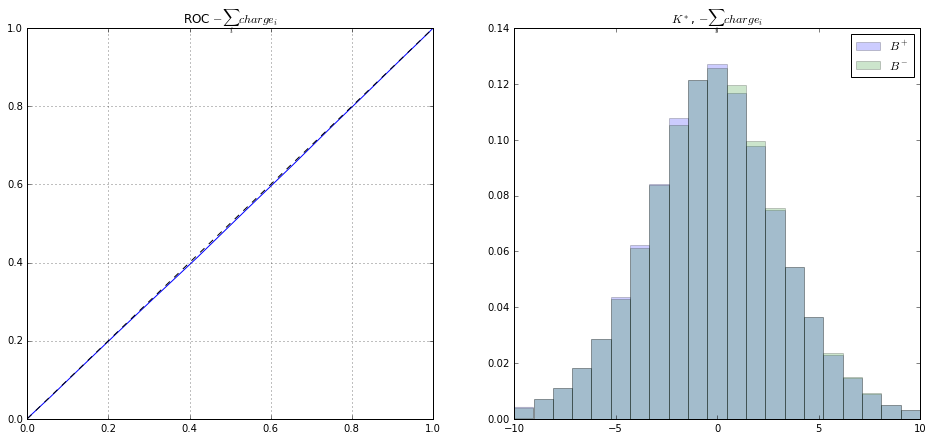

In [19]:
mean_kstar = compute_sum_of_charges(data_kstar, "$K^*$", bins=21,
                                    event_id_column='event_id', show_with_signal=False)

In [20]:
mean_kstar

,$B^+$,$B^-$,ROC AUC,name
0,-0.229751,-0.198957,0.497226,$K^*$


#### inverting of SS+NAN tags

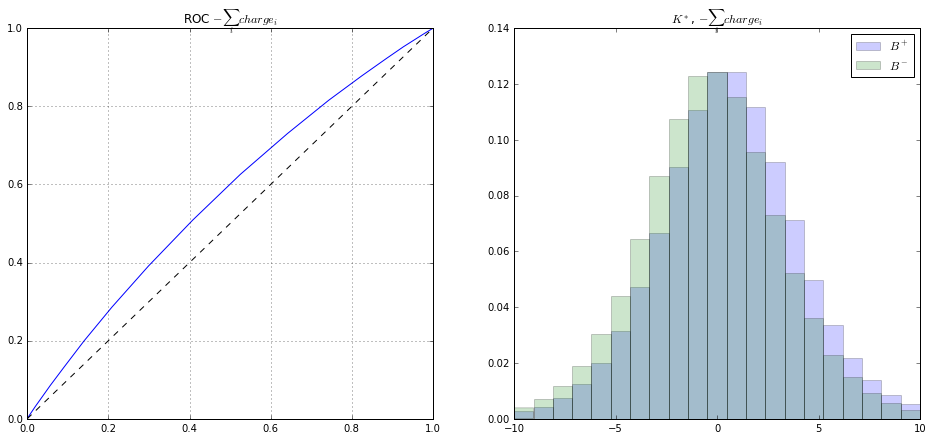

In [21]:
data_kstar_new = data_kstar.copy()
data_kstar_new.ix[data_kstar.OS_SS >= 0, 'signTrack'] *= -1
mean_kstar_invert = compute_sum_of_charges(data_kstar_new, "$K^*$", bins=21,
                                           event_id_column='event_id', show_with_signal=False)

In [22]:
mean_kstar_invert

,$B^+$,$B^-$,ROC AUC,name
0,0.589938,-0.272753,0.568555,$K^*$


### take predictions

In [23]:
p_kstar = tt_folding.predict_proba(data_kstar)[:, 1]
p_kstar_ss = tt_os_ss.predict_proba(data_kstar)[:, 1]
p_kstar_ss_calib = calibrator_os_ss.predict_proba(p_kstar_ss)

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


### AUCs for each type of tags

In [24]:
for br in ['xFlag', 'OS_SS']:
    print br
    for name, group in dict_SS_OS.items():
        mask = data_kstar[br].values == group
        print name, 'K*', roc_auc_score((data_kstar.signTrack.values * data_kstar.signB.values > 0)[mask], 
                                           p_kstar[mask]),
        mask = k_data[br].values == group
        print 'K+/-', roc_auc_score(k_data.label.values[mask], k_data.part_prob.values[mask])
    print '\n'

xFlag
SS K* 0.474724704605 K+/- 0.766637093113
NAN K* 0.500885131526 K+/- 0.508277578652
OS K* 0.54091439207 K+/- 0.567003275568


OS_SS
SS K* 0.473400244142 K+/- 0.627174471455
NAN K* 0.499893140594 K+/- 0.507704435074
OS K* 0.54259813649 K+/- 0.57150133175




## Final quality

### inverting tags

Calibrate tracks
tracks AUC 0.502845557026 calibrated tracks AUC 0.515468337051


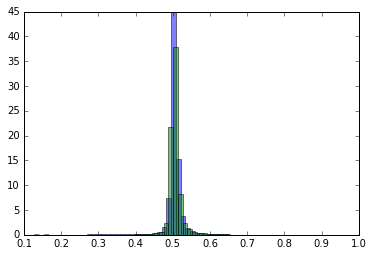

Calibrate B
dilution, without B calibration 0.0575545507085
B AUC, without calibration 0.627836828269 0.627836461091
B AUC, with calibration 0.627799678081 0.627799312191


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,"K*, OS/SS tag inverting",99.999537,0.152203,0.082168,0,8.216715,0.012506,62.779931,0


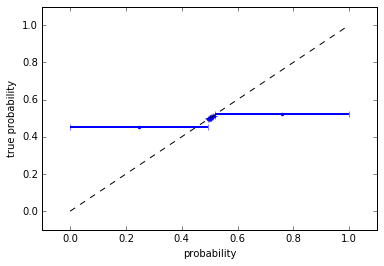

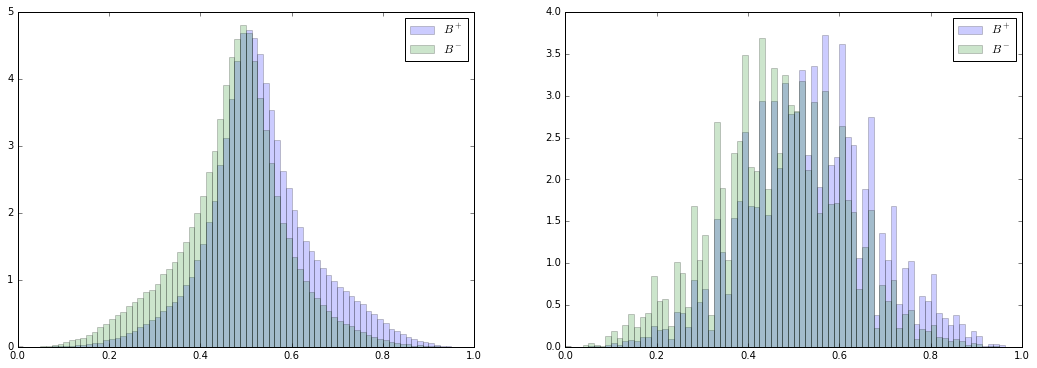

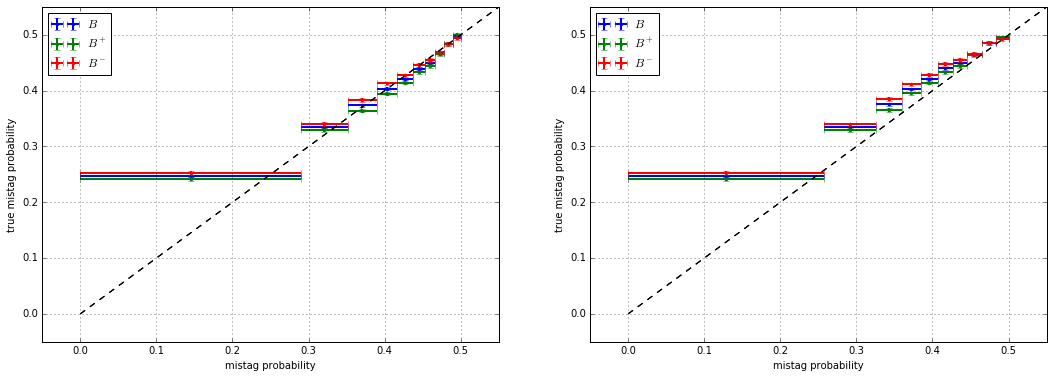

In [26]:
table_kstar = estimate(p_kstar, data_kstar,
                       N_B_kstar, name="K*, OS/SS tag inverting", calibrator_tracks=calibrator_tracks, 
                       calibrator_B=calibrator_B, 
                       mask_to_invert=data_kstar.OS_SS.values >= 0)
table_kstar

### inverting by BDT(SS/OS)

Calibrate tracks
tracks AUC 0.502845557026 calibrated tracks AUC 0.511842709627


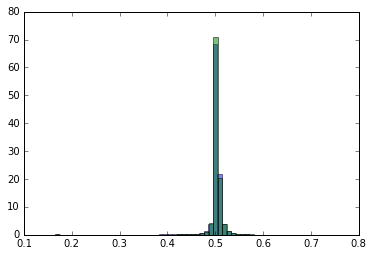

Calibrate B
dilution, without B calibration 0.0390205518811
B AUC, without calibration 0.618916116949 0.618915752063
B AUC, with calibration 0.618824056017 0.618823688227


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* BDT inverting,99.999537,0.152203,0.057577,0,5.757643,0.008763,61.882369,0


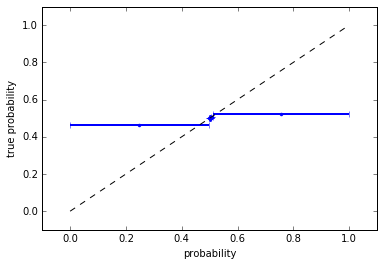

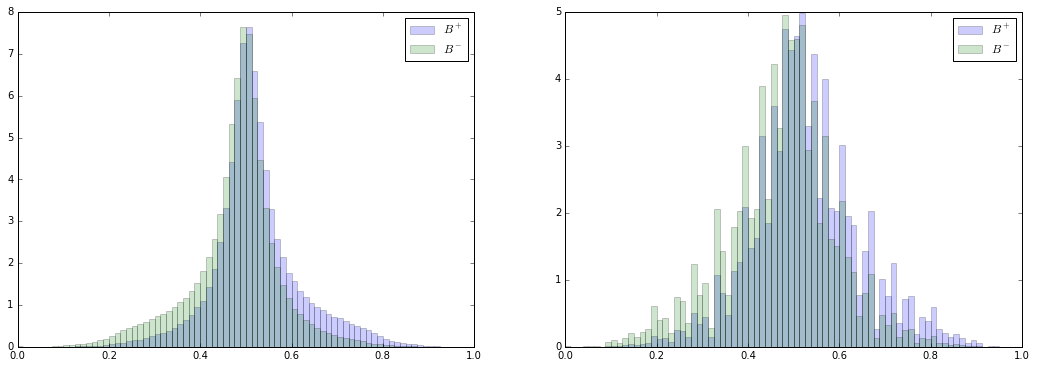

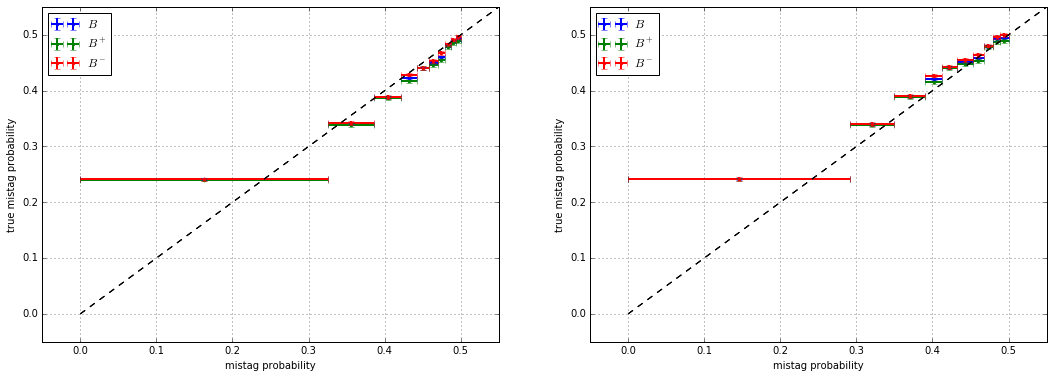

In [27]:
table_kstar_BDT = estimate(p_kstar, data_kstar,
                           N_B_kstar, name="K* BDT inverting", calibrator_tracks=calibrator_tracks, 
                           calibrator_B=calibrator_B, 
                           prior=p_kstar_ss_calib)
table_kstar_BDT

### self training

In [29]:
data_kstar['label'] = (data_kstar.signB.values * data_kstar.signTrack.values > 0) * 1

In [30]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=3000, depth=6,
                                  max_features=15, n_threads=12)
tt_folding_kstar = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                          train_features=features, group_feature='group_column')
%time tt_folding_kstar.fit(data_kstar, data_kstar.label)

CPU times: user 30min 37s, sys: 11.8 s, total: 30min 49s
Wall time: 5min 17s


FoldingGroupClassifier(base_estimator=SklearnClassifier(clf=DecisionTrainClassifier(bootstrap=True, depth=6, l2_regularization=100.0,
            learning_rate=0.02, loss=None, max_features=15,
            n_estimators=3000, n_threads=12, train_features=None,
            update_step=4, use_friedman_mse=True),
         features=None),
            group_feature='group_column', n_folds=2, parallel_profile=None,
            random_state=11,
            train_features=['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm', 'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs'])

In [61]:
p_kstar_own = tt_folding_kstar.predict_proba(data_kstar)[:, 1]
roc_auc_score(data_kstar.label.values, p_kstar_own)

KFold prediction using folds column


0.51628903131519366

Calibrate tracks
tracks AUC 0.516289031315 calibrated tracks AUC 0.516078626507


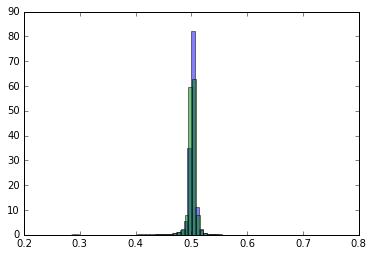

Calibrate B
dilution, without B calibration 0.0135180899394
B AUC, without calibration 0.628763466421 0.628763090635
B AUC, with calibration 0.628546293109 0.628545919013


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* self training,99.999537,0.152203,0.054413,0,5.441249,0.008282,62.854592,0


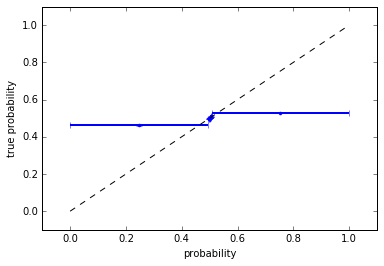

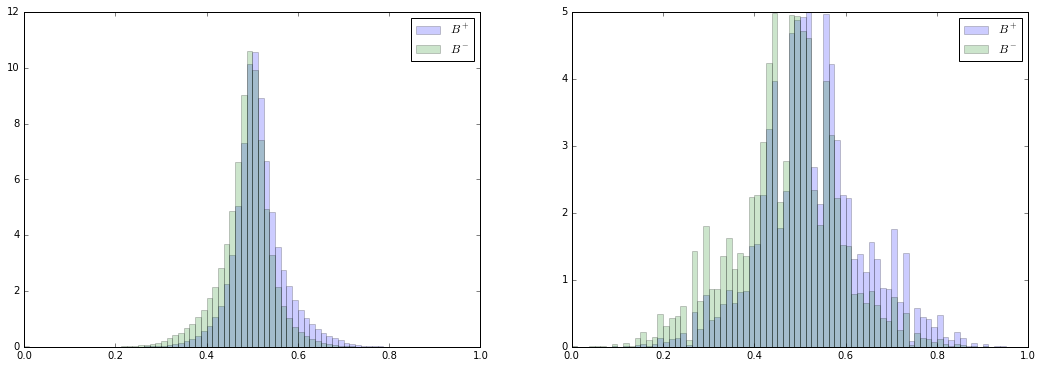

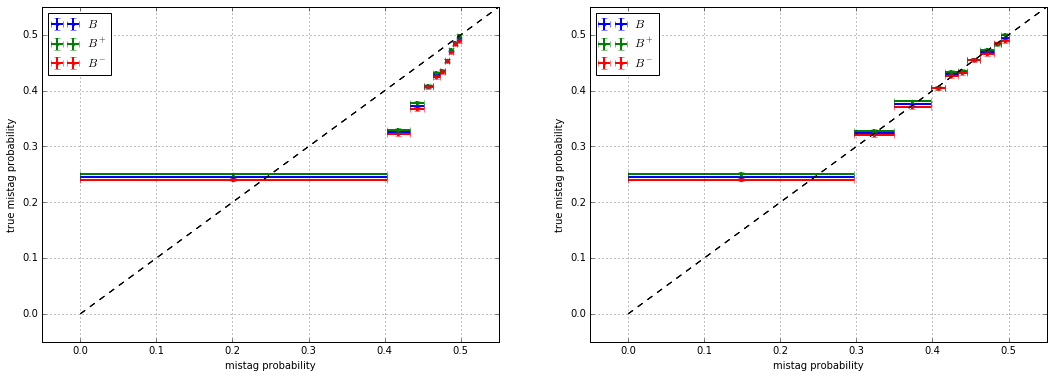

In [52]:
table_kstar_self = estimate(p_kstar_own, data_kstar,
                            N_B_kstar, name="K* self training")
table_kstar_self

# MC $B_d \to J\psi K_s$

In [45]:
data_ks = pandas.DataFrame(root_numpy.root2array('datasets/MC/csv/Bd_JPsiKs/Tracks.root'))
data_ks = data_ks.ix[numpy.isfinite(data_ks.IPs), :]
add_features(data_ks)
get_events_statistics(data_ks)

{'Events': 130875, 'parts': 2837721}

In [46]:
# N_B_ks = compute_N_B_events_MC('datasets/MC/csv/Bd_JPsiKs/Tracks.root',
#                                'datasets/MC/csv/Bd_JPsiKs/Vertices.root')
N_B_ks = 130875.0

### initial selection

In [47]:
data_ks = data_ks.query(selection)
get_events_statistics(data_ks)

{'Events': 130875, 'parts': 2773602}

## Sum of charges

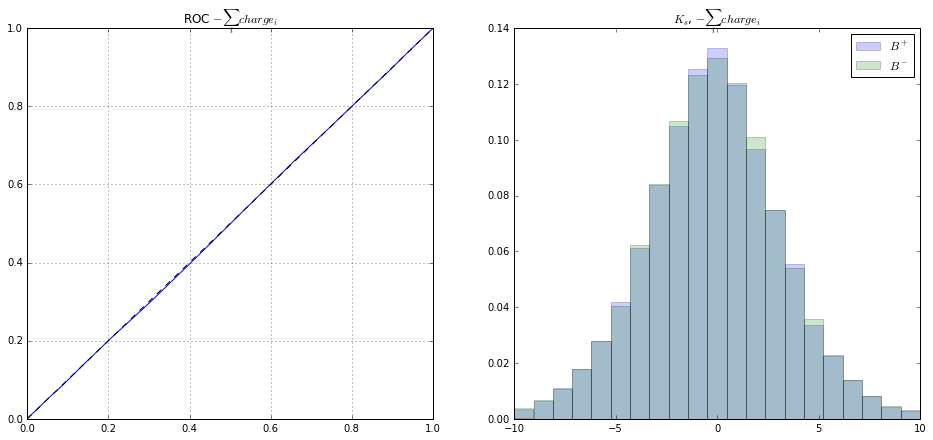

In [48]:
mean_ks = compute_sum_of_charges(data_ks, "$K_s$", bins=21, event_id_column='event_id', show_with_signal=False)

In [49]:
mean_ks

,$B^+$,$B^-$,ROC AUC,name
0,-0.21589,-0.211198,0.499283,$K_s$


#### inverting of SS+NAN tags

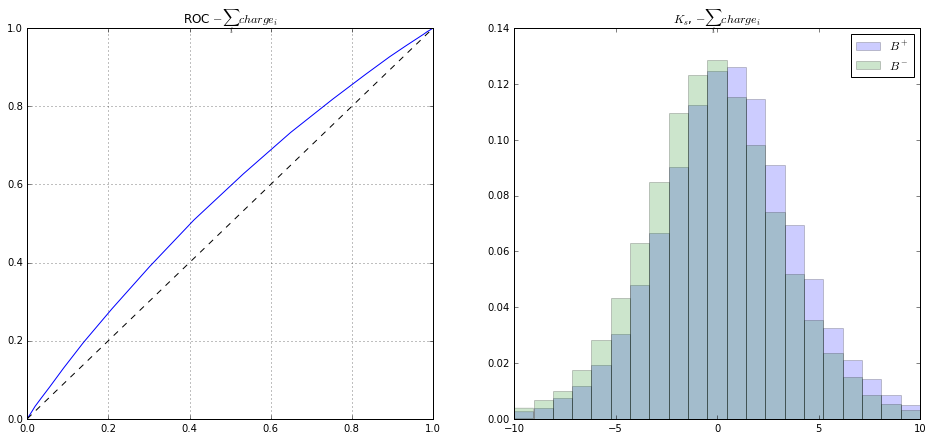

In [50]:
data_ks_new = data_ks.copy()
data_ks_new.ix[data_ks.OS_SS >= 0, 'signTrack'] *= -1
mean_ks_invert = compute_sum_of_charges(data_ks_new, "$K_s$", 
                                        bins=21, event_id_column='event_id', show_with_signal=False)

In [51]:
mean_ks_invert

,$B^+$,$B^-$,ROC AUC,name
0,0.594043,-0.214159,0.565251,$K_s$


### take predictions

In [53]:
p_ks = tt_folding.predict_proba(data_ks)[:, 1]
p_ks_ss = tt_os_ss.predict_proba(data_ks)[:, 1]
p_ks_ss_calib = calibrator_os_ss.predict_proba(p_ks_ss)

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)


### AUCs for each type of tags

In [35]:
for name, group in dict_SS_OS.items():
    mask = data_ks.OS_SS.values == group
    print name, 'Ks', roc_auc_score((data_ks.signTrack.values * data_ks.signB.values > 0)[mask], p_ks[mask]),
    mask = k_data.OS_SS.values == group
    print 'K+-', roc_auc_score(k_data.label.values[mask], k_data.part_prob.values[mask])

SS Ks 0.413454699368 K+- 0.627174471455
NAN Ks 0.495933567556 K+- 0.507704435074
OS Ks 0.572312664872 K+- 0.57150133175


## Final quality

### inverting tags

Calibrate tracks
tracks AUC 0.502918639311 calibrated tracks AUC 0.51525728365


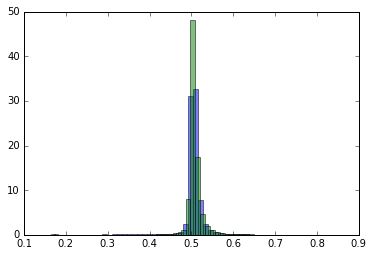

Calibrate B
dilution, without B calibration 0.0535660737947
B AUC, without calibration 0.623631189487 0.623631189487
B AUC, with calibration 0.623616365584 0.623616365584


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,"Ks, OS/SS tag inverting",100,0.276421,0.07716,0,7.715992,0.021329,62.361637,0


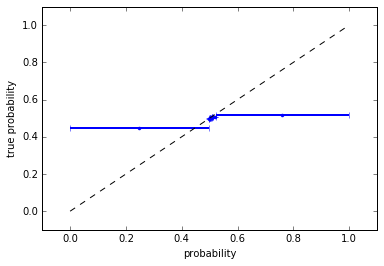

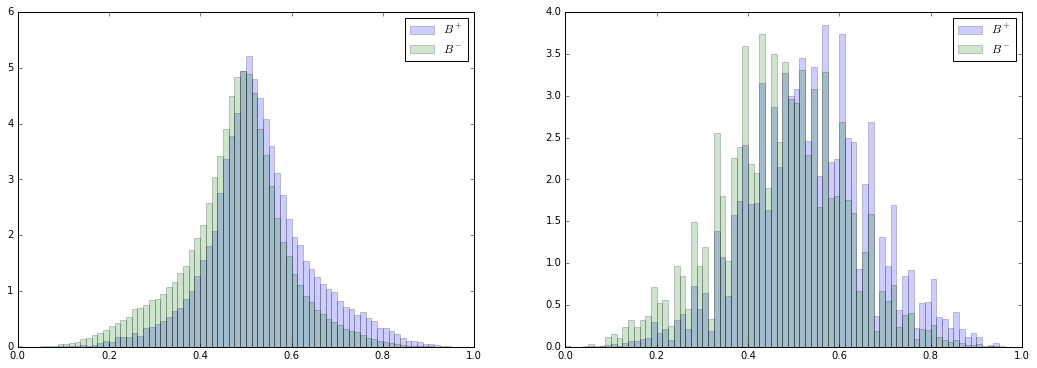

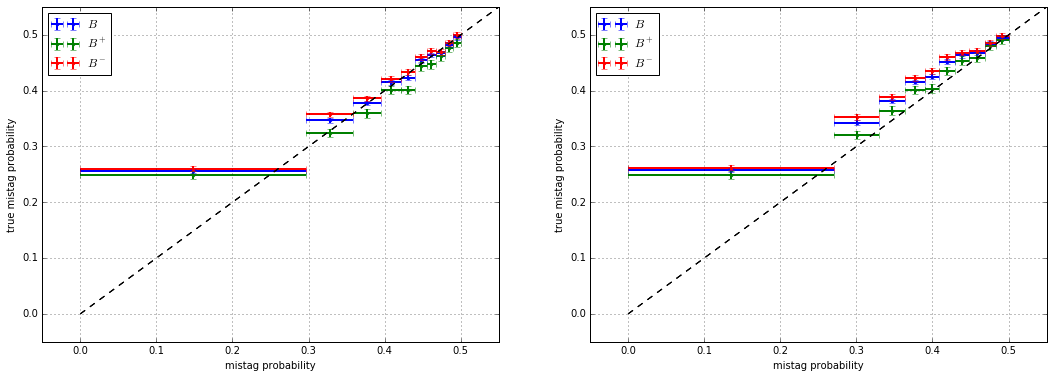

In [54]:
table_ks = estimate(p_ks, data_ks,
                    N_B_ks, name="Ks, OS/SS tag inverting", calibrator_tracks=calibrator_tracks, 
                    calibrator_B=calibrator_B, 
                    mask_to_invert=data_ks.OS_SS.values >= 0)
table_ks

### inverting by BDT(SS/OS)

Calibrate tracks
tracks AUC 0.502918639311 calibrated tracks AUC 0.512196253756


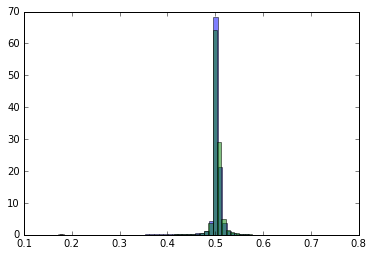

Calibrate B
dilution, without B calibration 0.037194453193
B AUC, without calibration 0.616689355937 0.616689355937
B AUC, with calibration 0.616665928547 0.616665928547


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,Ks BDT inverting,100,0.276421,0.054985,0,5.498515,0.015199,61.666593,0


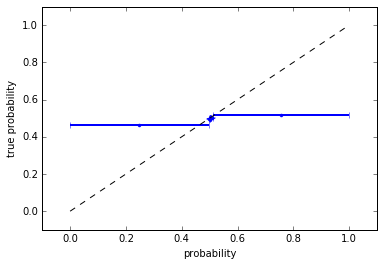

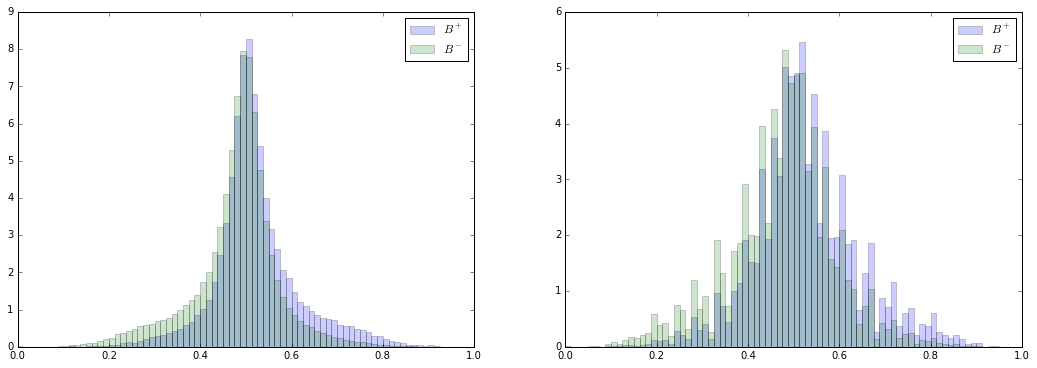

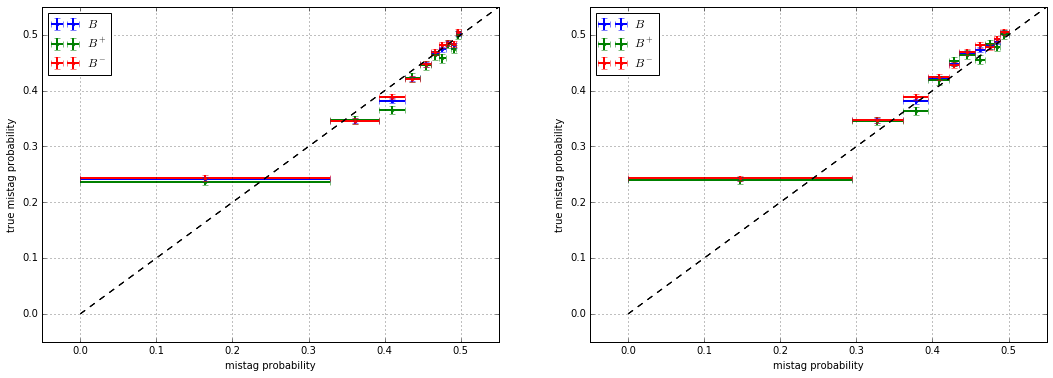

In [55]:
table_ks_BDT = estimate(p_ks, data_ks,
                        N_B_ks, name="Ks BDT inverting", calibrator_tracks=calibrator_tracks, 
                        calibrator_B=calibrator_B, 
                        prior=p_ks_ss_calib)
table_ks_BDT

## self training

In [58]:
data_ks['label'] = (data_ks.signB.values * data_ks.signTrack.values > 0) * 1
tt_base = DecisionTrainClassifier(learning_rate=0.1, n_estimators=3000, depth=6,
                                  max_features=15, n_threads=12)
tt_folding_ks = FoldingGroupClassifier(SklearnClassifier(tt_base), n_folds=2, random_state=11, 
                                       train_features=features, group_feature='group_column')
%time tt_folding_ks.fit(data_ks, data_ks.label)

CPU times: user 11min 38s, sys: 3.91 s, total: 11min 42s
Wall time: 1min 37s


FoldingGroupClassifier(base_estimator=SklearnClassifier(clf=DecisionTrainClassifier(bootstrap=True, depth=6, l2_regularization=100.0,
            learning_rate=0.1, loss=None, max_features=15,
            n_estimators=3000, n_threads=12, train_features=None,
            update_step=4, use_friedman_mse=True),
         features=None),
            group_feature='group_column', n_folds=2, parallel_profile=None,
            random_state=11,
            train_features=['cos_diff_phi', 'diff_pt', 'partPt', 'partP', 'nnkrec', 'diff_eta', 'EOverP', 'ptB', 'sum_PID_mu_k', 'proj', 'PIDNNe', 'sum_PID_k_e', 'PIDNNk', 'sum_PID_mu_e', 'PIDNNm', 'phi', 'IP', 'IPerr', 'IPs', 'veloch', 'max_PID_k_e', 'ghostProb', 'IPPU', 'eta', 'max_PID_mu_e', 'max_PID_mu_k', 'partlcs'])

In [60]:
p_ks_own = tt_folding_ks.predict_proba(data_ks)[:, 1]
roc_auc_score(data_ks.label, p_ks_own)

KFold prediction using folds column


0.51473014668247119

Calibrate tracks
tracks AUC 0.514730146682 calibrated tracks AUC 0.514704201059


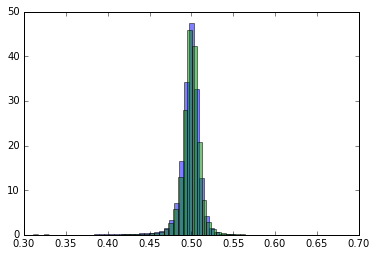

Calibrate B
dilution, without B calibration 0.0151531078296
B AUC, without calibration 0.598374936486 0.598374936486
B AUC, with calibration 0.598141797965 0.598141797965


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,Ks self training,100,0.276421,0.041222,0,4.122234,0.011395,59.81418,0


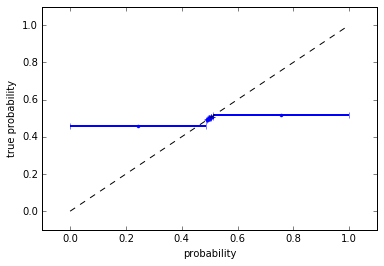

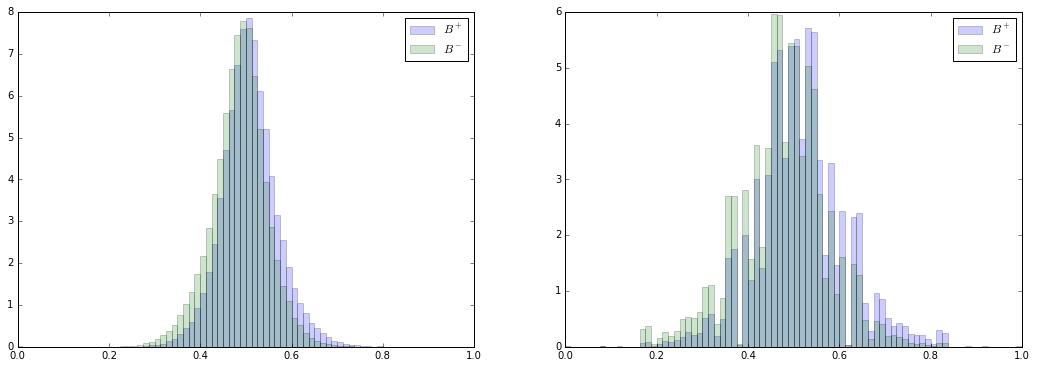

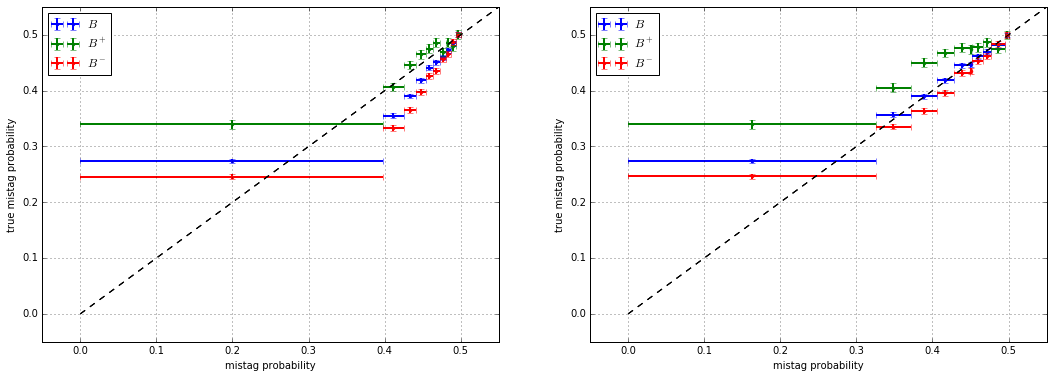

In [62]:
table_ks_self = estimate(p_ks_own, data_ks,
                         N_B_ks, name="Ks self training")
table_ks_self

# Final comparison

In [63]:
pandas.concat([table_kstar, table_ks])

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,"K*, OS/SS tag inverting",99.999537,0.152203,0.082168,0,8.216715,0.012506,62.779931,0
0,"Ks, OS/SS tag inverting",100.000000,0.276421,0.077160,0,7.715992,0.021329,62.361637,0


In [64]:
pandas.concat([table_kstar_BDT, table_ks_BDT])

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* BDT inverting,99.999537,0.152203,0.057577,0,5.757643,0.008763,61.882369,0
0,Ks BDT inverting,100.000000,0.276421,0.054985,0,5.498515,0.015199,61.666593,0


In [65]:
pandas.concat([table_kstar_self, table_ks_self])

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,K* self training,99.999537,0.152203,0.054413,0,5.441249,0.008282,62.854592,0
0,Ks self training,100.000000,0.276421,0.041222,0,4.122234,0.011395,59.814180,0
